# Quantization: Bitsandbytes 4-bit Baselines

**Objective:** Compare simple quantization methods and bitsandbytes 4-bit (NF4/FP4) against an FP16 baseline.

**Key Questions:**
1. How do simple uniform methods compare to bitsandbytes NF4/FP4 at 4-bit?
2. Does NF4 (Gaussian-optimized) beat FP4 (uniform log-spacing)? This validates our Gaussian assumption.
3. Is weight MSE a good proxy for functional distortion (output MSE)?

**Expected findings:**
- NF4 should beat FP4, confirming near-Gaussian weight distributions
- Simple uniform methods should underperform NF4/FP4 at equal bit-width
- Weight importance should be non-uniform (functional MSE != weight MSE)

In [ ]:
# === AUTHENTICATION (required) ===
from huggingface_hub import login

# Paste your token directly as a string argument
login(token="....")

# After running successfully, DELETE this cell or clear the token string

In [2]:
# dependency install
%pip -q install -U transformers accelerate bitsandbytes

#restart after installing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 119.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 18.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 50.5 MB/s eta 0:00:00


In [1]:
# Core imports
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [2]:
# Load model + tokenizer (Llama 3.2 1B by default)
model_id = "meta-llama/Llama-3.2-1B"
tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)

# FP16 baseline
m_fp16 = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
).eval()

# Keep the original variable name for downstream cells
model = m_fp16

print(f"Loaded: {model_id}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/146 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Loaded: meta-llama/Llama-3.2-1B
Parameters: 1,235,814,400


In [14]:
# Utility functions needed for baselines

def symmetric_quantize(x, bits, per_channel=False, axis=1):
    """
    Symmetric uniform quantization to signed integers.
    per_channel=True uses per-output-channel scaling (axis=1 for [out, in]).
    Returns dequantized array and scale(s).
    """
    x = x.astype(np.float32)
    qmax = (2 ** (bits - 1)) - 1

    if per_channel:
        max_abs = np.max(np.abs(x), axis=axis, keepdims=True) + 1e-12
        scale = max_abs / qmax
        q = np.clip(np.round(x / scale), -qmax, qmax)
        dq = q * scale
    else:
        max_abs = float(np.max(np.abs(x)))
        scale = max_abs / qmax if max_abs > 0 else 1.0
        q = np.clip(np.round(x / scale), -qmax, qmax)
        dq = q * scale

    return dq.astype(np.float32), scale


def shannon_distortion(sigma_sq, rate_bits):
    return sigma_sq / (4 ** rate_bits)


def gap_bits(mse, d_shannon):
    if mse <= 0 or d_shannon <= 0:
        return 0.0
    return 0.5 * math.log2(mse / d_shannon)


def quantize_group(weights, bits, group_size=128):
    flat = weights.flatten().astype(np.float32)
    n = len(flat)

    pad_size = (group_size - n % group_size) % group_size
    if pad_size > 0:
        flat_padded = np.concatenate([flat, np.zeros(pad_size, dtype=np.float32)])
    else:
        flat_padded = flat

    groups = flat_padded.reshape(-1, group_size)
    levels = 2 ** bits
    quantized_groups = np.zeros_like(groups)

    for i in range(groups.shape[0]):
        group = groups[i]
        max_abs = float(np.max(np.abs(group)))
        if max_abs == 0:
            quantized_groups[i] = group
            continue
        scale = (2 * max_abs) / (levels - 1)
        quantized_groups[i] = np.round(group / scale) * scale

    quantized = quantized_groups.flatten()[:n]
    mse = float(np.mean((flat - quantized) ** 2))
    effective_bits = bits + 16 / group_size
    return quantized, mse, effective_bits

## Load bitsandbytes 4-bit Models (NF4/FP4)

Use transformers + bitsandbytes to load 4-bit NF4 and FP4 checkpoints.

In [15]:
# ============================================
# Load bitsandbytes 4-bit Quantized Models
# ============================================

# FP16 baseline already loaded as `model` (m_fp16)

print("Loading bnb 4-bit NF4 model...")
try:
    q_nf4 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4")
    m_nf4 = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        quantization_config=q_nf4,
    ).eval()

    model_nf4 = m_nf4
    NF4_AVAILABLE = True
    print("✓ NF4 model loaded successfully")

except Exception as e:
    print(f"✗ NF4 model loading failed: {e}")
    print("  Install with: pip install bitsandbytes")
    model_nf4 = None
    NF4_AVAILABLE = False

print("\nLoading bnb 4-bit FP4 model...")
try:
    q_fp4 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="fp4")
    m_fp4 = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        quantization_config=q_fp4,
    ).eval()

    model_fp4 = m_fp4
    FP4_AVAILABLE = True
    print("✓ FP4 model loaded successfully")

except Exception as e:
    print(f"✗ FP4 model loading failed: {e}")
    model_fp4 = None
    FP4_AVAILABLE = False

print(f"\nModel availability summary:")
print(f"  FP16 baseline: ✓ (already loaded)")
print(f"  bnb 4-bit NF4: {'✓' if NF4_AVAILABLE else '✗'}")
print(f"  bnb 4-bit FP4: {'✓' if FP4_AVAILABLE else '✗'}")

Loading bnb 4-bit NF4 model...


Loading weights:   0%|          | 0/146 [00:00<?, ?it/s]

✓ NF4 model loaded successfully

Loading bnb 4-bit FP4 model...


Loading weights:   0%|          | 0/146 [00:00<?, ?it/s]

✓ FP4 model loaded successfully

Model availability summary:
  FP16 baseline: ✓ (already loaded)
  bnb 4-bit NF4: ✓
  bnb 4-bit FP4: ✓


In [16]:
# ============================================
# Extract and Compare Weights Across Models
# ============================================

# Target layer for comparison
target_layer = 8
target_proj = "mlp.down_proj"

# Extract FP16 baseline weights (convert to fp32 for comparison)
w_fp16 = model.model.layers[target_layer].mlp.down_proj.weight.detach().cpu().float().numpy()

def extract_module_weight(module):
    """Return dequantized weights for bnb 4-bit modules, or raw weights otherwise."""
    w = module.weight
    if hasattr(w, "quant_state"):
        try:
            import bitsandbytes as bnb
            w_deq = bnb.functional.dequantize_4bit(w.data, w.quant_state)
            return w_deq.detach().cpu().float().numpy()
        except Exception:
            pass
        if hasattr(w, "dequantize"):
            return w.dequantize().detach().cpu().float().numpy()
    return w.detach().cpu().float().numpy()

print(f"Analyzing layer {target_layer}, projection: {target_proj}")
print(f"Weight shape: {w_fp16.shape}")
print(f"FP16 variance: {np.var(w_fp16):.6e}")
print(f"FP16 kurtosis: {np.mean(((w_fp16 - w_fp16.mean()) / w_fp16.std())**4):.2f}")
print()

# Container for results
sota_results = {
    "method": ["FP16 (baseline)"],
    "mse": [0.0],
    "bits_per_weight": [16.0],
    "sqnr_db": [float('inf')],
}

# Extract NF4 weights if available
if NF4_AVAILABLE and model_nf4 is not None:
    try:
        w_nf4 = extract_module_weight(model_nf4.model.layers[target_layer].mlp.down_proj)
        mse_nf4 = np.mean((w_fp16 - w_nf4) ** 2)
        sqnr_nf4 = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_nf4) if mse_nf4 > 0 else float('inf')
        
        sota_results["method"].append("bnb 4-bit NF4")
        sota_results["mse"].append(mse_nf4)
        sota_results["bits_per_weight"].append(4.0)
        sota_results["sqnr_db"].append(sqnr_nf4)
        
        print(f"bnb 4-bit NF4:")
        print(f"  MSE:     {mse_nf4:.2e}")
        print(f"  SQNR:    {sqnr_nf4:.2f} dB")
        print(f"  Max err: {np.max(np.abs(w_fp16 - w_nf4)):.2e}")
        print()
    except Exception as e:
        print(f"Failed to extract NF4 weights: {e}\n")

# Extract FP4 weights if available
if FP4_AVAILABLE and model_fp4 is not None:
    try:
        w_fp4 = extract_module_weight(model_fp4.model.layers[target_layer].mlp.down_proj)
        mse_fp4 = np.mean((w_fp16 - w_fp4) ** 2)
        sqnr_fp4 = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_fp4) if mse_fp4 > 0 else float('inf')
        
        sota_results["method"].append("bnb 4-bit FP4")
        sota_results["mse"].append(mse_fp4)
        sota_results["bits_per_weight"].append(4.0)
        sota_results["sqnr_db"].append(sqnr_fp4)
        
        print(f"bnb 4-bit FP4:")
        print(f"  MSE:     {mse_fp4:.2e}")
        print(f"  SQNR:    {sqnr_fp4:.2f} dB")
        print(f"  Max err: {np.max(np.abs(w_fp16 - w_fp4)):.2e}")
        print()
    except Exception as e:
        print(f"Failed to extract FP4 weights: {e}\n")

# Add simple methods for comparison (4-bit)
print("Comparing to simple quantization methods:")

# Per-tensor symmetric 4-bit
dq_per_tensor, _ = symmetric_quantize(w_fp16, 4, per_channel=False)
mse_per_tensor = np.mean((w_fp16 - dq_per_tensor) ** 2)
sqnr_per_tensor = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_per_tensor)
sota_results["method"].append("Simple per-tensor")
sota_results["mse"].append(mse_per_tensor)
sota_results["bits_per_weight"].append(4.0)
sota_results["sqnr_db"].append(sqnr_per_tensor)
print(f"  Simple per-tensor 4-bit: MSE={mse_per_tensor:.2e}, SQNR={sqnr_per_tensor:.2f} dB")

# Per-channel symmetric 4-bit
dq_per_channel, _ = symmetric_quantize(w_fp16, 4, per_channel=True, axis=1)
mse_per_channel = np.mean((w_fp16 - dq_per_channel) ** 2)
sqnr_per_channel = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_per_channel)
sota_results["method"].append("Simple per-channel")
sota_results["mse"].append(mse_per_channel)
sota_results["bits_per_weight"].append(4.0)
sota_results["sqnr_db"].append(sqnr_per_channel)
print(f"  Simple per-channel 4-bit: MSE={mse_per_channel:.2e}, SQNR={sqnr_per_channel:.2f} dB")

# Group quantization (g=128)
_, mse_group128, eff_bits_g128 = quantize_group(w_fp16, 4, group_size=128)
sqnr_group128 = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_group128)
sota_results["method"].append("Group g=128")
sota_results["mse"].append(mse_group128)
sota_results["bits_per_weight"].append(eff_bits_g128)
sota_results["sqnr_db"].append(sqnr_group128)
print(f"  Group g=128 (4-bit): MSE={mse_group128:.2e}, SQNR={sqnr_group128:.2f} dB, eff_bits={eff_bits_g128:.3f}")

# Shannon bound (Gaussian assumption)
sigma_sq = np.var(w_fp16)
d_shannon_4bit = shannon_distortion(sigma_sq, 4.0)
sqnr_shannon = 10 * np.log10(np.mean(w_fp16 ** 2) / d_shannon_4bit)
sota_results["method"].append("Shannon bound (4-bit)")
sota_results["mse"].append(d_shannon_4bit)
sota_results["bits_per_weight"].append(4.0)
sota_results["sqnr_db"].append(sqnr_shannon)
print(f"  Shannon bound (4-bit): MSE={d_shannon_4bit:.2e}, SQNR={sqnr_shannon:.2f} dB")
print()

# Create summary DataFrame
df_sota = pd.DataFrame(sota_results)
df_sota = df_sota.sort_values("mse", ascending=True)
print("=" * 70)
print("SUMMARY TABLE (sorted by MSE, lower is better)")
print("=" * 70)
print(df_sota.to_string(index=False))
print("=" * 70)

Analyzing layer 8, projection: mlp.down_proj
Weight shape: (2048, 8192)
FP16 variance: 2.609423e-04
FP16 kurtosis: 4.24

bnb 4-bit NF4:
  MSE:     2.31e-06
  SQNR:    20.53 dB
  Max err: 3.91e-02

bnb 4-bit FP4:
  MSE:     4.24e-06
  SQNR:    17.90 dB
  Max err: 4.68e-02

Comparing to simple quantization methods:
  Simple per-tensor 4-bit: MSE=2.44e-04, SQNR=0.30 dB
  Simple per-channel 4-bit: MSE=1.17e-05, SQNR=13.48 dB
  Group g=128 (4-bit): MSE=3.83e-06, SQNR=18.33 dB, eff_bits=4.125
  Shannon bound (4-bit): MSE=1.02e-06, SQNR=24.08 dB

SUMMARY TABLE (sorted by MSE, lower is better)
               method      mse  bits_per_weight   sqnr_db
      FP16 (baseline) 0.000000           16.000       inf
Shannon bound (4-bit) 0.000001            4.000 24.082397
        bnb 4-bit NF4 0.000002            4.000 20.534214
          Group g=128 0.000004            4.125 18.332127
        bnb 4-bit FP4 0.000004            4.000 17.895525
   Simple per-channel 0.000012            4.000 13.482569
 

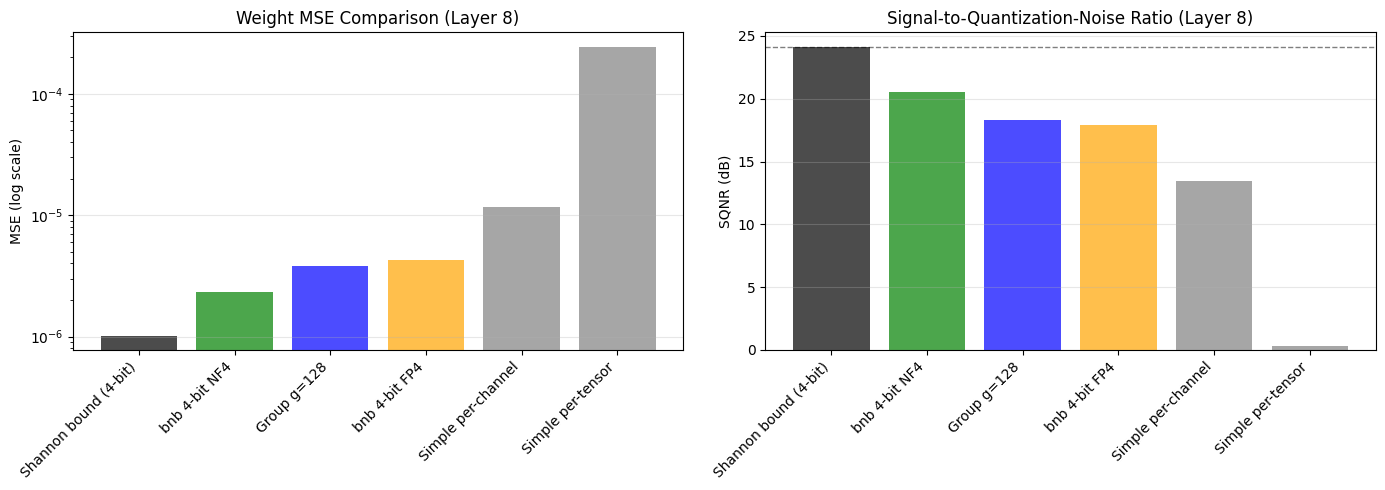


Gap analysis (bits from Shannon bound at 4-bit):
bnb 4-bit NF4            : +0.589 bits gap
Group g=128              : +0.955 bits gap
bnb 4-bit FP4            : +1.028 bits gap
Simple per-channel       : +1.761 bits gap
Simple per-tensor        : +3.951 bits gap


In [17]:
# ============================================
# Visualize 4-bit Comparison
# ============================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MSE comparison (bar chart)
methods_plot = [m for m in df_sota["method"] if m != "FP16 (baseline)"]
mses_plot = [df_sota[df_sota["method"] == m]["mse"].values[0] for m in methods_plot]

colors = []
for m in methods_plot:
    if "Shannon" in m:
        colors.append('black')
    elif "NF4" in m:
        colors.append('green')
    elif "FP4" in m:
        colors.append('orange')
    elif "Group" in m:
        colors.append('blue')
    else:
        colors.append('gray')

ax1.bar(range(len(methods_plot)), mses_plot, color=colors, alpha=0.7)
ax1.set_xticks(range(len(methods_plot)))
ax1.set_xticklabels(methods_plot, rotation=45, ha='right')
ax1.set_yscale('log')
ax1.set_ylabel('MSE (log scale)')
ax1.set_title(f'Weight MSE Comparison (Layer {target_layer})')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: SQNR comparison (higher is better)
sqnrs_plot = [df_sota[df_sota["method"] == m]["sqnr_db"].values[0] for m in methods_plot]
sqnrs_plot = [s if s != float('inf') else 100 for s in sqnrs_plot]

ax2.bar(range(len(methods_plot)), sqnrs_plot, color=colors, alpha=0.7)
ax2.set_xticks(range(len(methods_plot)))
ax2.set_xticklabels(methods_plot, rotation=45, ha='right')
ax2.set_ylabel('SQNR (dB)')
ax2.set_title(f'Signal-to-Quantization-Noise Ratio (Layer {target_layer})')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=sqnr_shannon, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Shannon bound')

plt.tight_layout()
plt.show()

# Calculate and display gaps
print("\nGap analysis (bits from Shannon bound at 4-bit):")
print("=" * 60)
for method in methods_plot:
    if "Shannon" in method:
        continue
    row = df_sota[df_sota["method"] == method].iloc[0]
    mse = row["mse"]
    gap = gap_bits(mse, d_shannon_4bit)
    print(f"{method:25s}: {gap:+.3f} bits gap")
print("=" * 60)

## Compare bitsandbytes NF4 vs FP4

**Hypothesis:** If weights are near-Gaussian, NF4 (optimized for Gaussian) should outperform FP4 (uniform log-spacing).

In [18]:
# ============================================
# Bitsandbytes models already loaded above
# ============================================

NF4_AVAILABLE = NF4_AVAILABLE if "NF4_AVAILABLE" in globals() else False
FP4_AVAILABLE = FP4_AVAILABLE if "FP4_AVAILABLE" in globals() else False

print("Using preloaded bitsandbytes models:")
print(f"  NF4: {'✓' if NF4_AVAILABLE else '✗'}")
print(f"  FP4: {'✓' if FP4_AVAILABLE else '✗'}")

Using preloaded bitsandbytes models:
  NF4: ✓
  FP4: ✓


In [19]:
# ============================================
# Extract and Compare NF4 vs FP4 Weights
# ============================================

bnb_results = {
    "method": [],
    "mse": [],
    "sqnr_db": [],
}

# We already have FP16 baseline from earlier
w_fp16_ref = model.model.layers[target_layer].mlp.down_proj.weight.detach().cpu().float().numpy()

print(f"Comparing NF4 vs FP4 on layer {target_layer}, {target_proj}")
print(f"FP16 reference shape: {w_fp16_ref.shape}")
print()

if "extract_module_weight" not in globals():
    def extract_module_weight(module):
        """Return dequantized weights for bnb 4-bit modules, or raw weights otherwise."""
        w = module.weight
        if hasattr(w, "quant_state"):
            try:
                import bitsandbytes as bnb
                w_deq = bnb.functional.dequantize_4bit(w.data, w.quant_state)
                return w_deq.detach().cpu().float().numpy()
            except Exception:
                pass
            if hasattr(w, "dequantize"):
                return w.dequantize().detach().cpu().float().numpy()
        return w.detach().cpu().float().numpy()

# Extract NF4 weights
if NF4_AVAILABLE and model_nf4 is not None:
    try:
        w_nf4 = extract_module_weight(model_nf4.model.layers[target_layer].mlp.down_proj)
        
        mse_nf4 = np.mean((w_fp16_ref - w_nf4) ** 2)
        sqnr_nf4 = 10 * np.log10(np.mean(w_fp16_ref ** 2) / mse_nf4) if mse_nf4 > 0 else float('inf')
        
        bnb_results["method"].append("bnb 4-bit NF4")
        bnb_results["mse"].append(mse_nf4)
        bnb_results["sqnr_db"].append(sqnr_nf4)
        
        print(f"bnb 4-bit NF4 (Gaussian-optimized):")
        print(f"  MSE:     {mse_nf4:.2e}")
        print(f"  SQNR:    {sqnr_nf4:.2f} dB")
        print(f"  Max err: {np.max(np.abs(w_fp16_ref - w_nf4)):.2e}")
        print()
        
    except Exception as e:
        print(f"Failed to extract NF4 weights: {e}\n")

# Extract FP4 weights
if FP4_AVAILABLE and model_fp4 is not None:
    try:
        w_fp4 = extract_module_weight(model_fp4.model.layers[target_layer].mlp.down_proj)
        
        mse_fp4 = np.mean((w_fp16_ref - w_fp4) ** 2)
        sqnr_fp4 = 10 * np.log10(np.mean(w_fp16_ref ** 2) / mse_fp4) if mse_fp4 > 0 else float('inf')
        
        bnb_results["method"].append("bnb 4-bit FP4")
        bnb_results["mse"].append(mse_fp4)
        bnb_results["sqnr_db"].append(sqnr_fp4)
        
        print(f"bnb 4-bit FP4 (uniform log-spacing):")
        print(f"  MSE:     {mse_fp4:.2e}")
        print(f"  SQNR:    {sqnr_fp4:.2f} dB")
        print(f"  Max err: {np.max(np.abs(w_fp16_ref - w_fp4)):.2e}")
        print()
        
    except Exception as e:
        print(f"Failed to extract FP4 weights: {e}\n")

# Add Shannon bound for reference
bnb_results["method"].append("Shannon bound")
bnb_results["mse"].append(d_shannon_4bit)
bnb_results["sqnr_db"].append(sqnr_shannon)

# Display comparison
if len(bnb_results["method"]) > 1:
    df_bnb = pd.DataFrame(bnb_results)
    df_bnb = df_bnb.sort_values("mse", ascending=True)
    print("=" * 60)
    print("NF4 vs FP4 COMPARISON")
    print("=" * 60)
    print(df_bnb.to_string(index=False))
    print("=" * 60)
    
    # Interpretation
    if NF4_AVAILABLE and FP4_AVAILABLE:
        improvement = (mse_fp4 - mse_nf4) / mse_fp4 * 100 if mse_fp4 > 0 else 0
        print(f"\nNF4 achieves {improvement:.1f}% lower MSE than FP4")
        if improvement > 5:
            print("✓ VALIDATION: NF4 significantly outperforms FP4")
            print("  → Confirms weights are approximately Gaussian")
        else:
            print("⚠ UNEXPECTED: NF4 and FP4 perform similarly")
            print("  → Weights may be more heavy-tailed than expected")
else:
    print("⚠ Could not load bitsandbytes models for comparison")

Comparing NF4 vs FP4 on layer 8, mlp.down_proj
FP16 reference shape: (2048, 8192)

bnb 4-bit NF4 (Gaussian-optimized):
  MSE:     2.31e-06
  SQNR:    20.53 dB
  Max err: 3.91e-02

bnb 4-bit FP4 (uniform log-spacing):
  MSE:     4.24e-06
  SQNR:    17.90 dB
  Max err: 4.68e-02

NF4 vs FP4 COMPARISON
       method      mse   sqnr_db
Shannon bound 0.000001 24.082397
bnb 4-bit NF4 0.000002 20.534214
bnb 4-bit FP4 0.000004 17.895525

NF4 achieves 45.5% lower MSE than FP4
✓ VALIDATION: NF4 significantly outperforms FP4
  → Confirms weights are approximately Gaussian


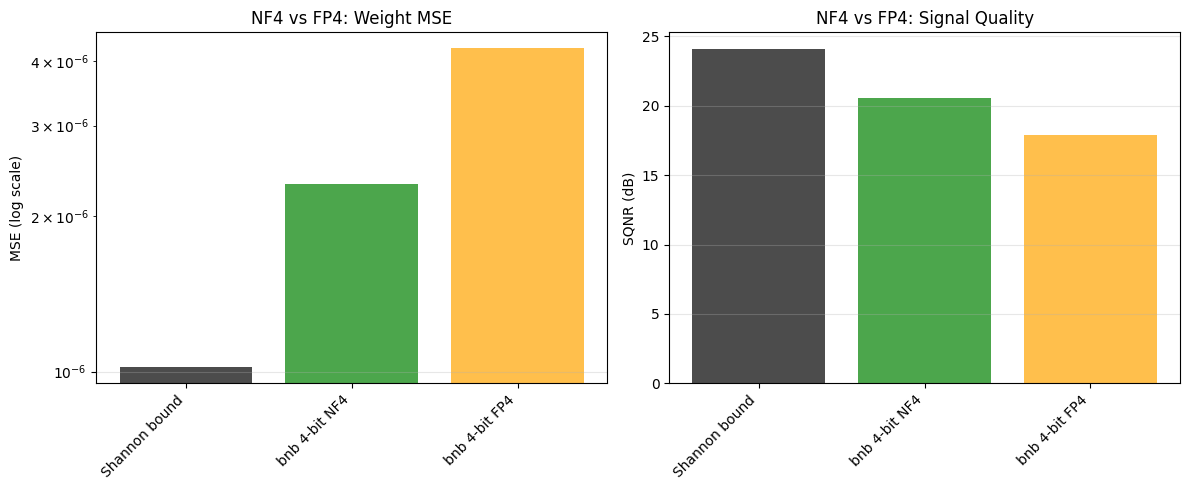


Gap from Shannon bound:
bnb 4-bit NF4            : +0.589 bits
bnb 4-bit FP4            : +1.028 bits


In [20]:
# ============================================
# Visualize NF4 vs FP4 Comparison
# ============================================

if len(bnb_results["method"]) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    methods = df_bnb["method"].tolist()
    mses = df_bnb["mse"].tolist()
    sqnrs = df_bnb["sqnr_db"].tolist()
    
    colors = ['green' if 'NF4' in m else 'orange' if 'FP4' in m else 'black' for m in methods]
    
    # MSE comparison
    ax1.bar(range(len(methods)), mses, color=colors, alpha=0.7)
    ax1.set_xticks(range(len(methods)))
    ax1.set_xticklabels(methods, rotation=45, ha='right')
    ax1.set_yscale('log')
    ax1.set_ylabel('MSE (log scale)')
    ax1.set_title('NF4 vs FP4: Weight MSE')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # SQNR comparison
    sqnrs_plot = [s if s != float('inf') else 100 for s in sqnrs]
    ax2.bar(range(len(methods)), sqnrs_plot, color=colors, alpha=0.7)
    ax2.set_xticks(range(len(methods)))
    ax2.set_xticklabels(methods, rotation=45, ha='right')
    ax2.set_ylabel('SQNR (dB)')
    ax2.set_title('NF4 vs FP4: Signal Quality')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Gap analysis
    print("\nGap from Shannon bound:")
    print("=" * 50)
    for method, mse in zip(methods, mses):
        if "Shannon" not in method:
            gap = gap_bits(mse, d_shannon_4bit)
            print(f"{method:25s}: {gap:+.3f} bits")
    print("=" * 50)
else:
    print("Visualization skipped - bitsandbytes models not available")

## Measure Functional Distortion

**Key Question:** Is weight MSE a good proxy for output distortion?

Insight: Some weights matter more than others. If weight importance is non-uniform, weight MSE won't perfectly correlate with functional MSE (output logits error).

In [21]:
# ============================================
# Prepare Calibration Data
# ============================================

print("Preparing calibration dataset for functional distortion measurement...")

calibration_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "Machine learning is a subset of artificial intelligence.",
    "The weather today is sunny with a chance of rain.",
    "Python is a popular programming language for data science.",
    "Transformers have revolutionized natural language processing.",
    "Climate change is one of the biggest challenges facing humanity.",
    "The stock market experienced volatility in recent months.",
    "Quantum computing promises to solve complex problems faster.",
    "Renewable energy sources include solar, wind, and hydroelectric power.",
    "The human brain contains approximately 86 billion neurons.",
]

tokenizer = tok

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

calibration_inputs = tokenizer(
    calibration_texts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

print(f"Calibration dataset: {len(calibration_texts)} samples")
print(f"Input shape: {calibration_inputs['input_ids'].shape}")
print()

Preparing calibration dataset for functional distortion measurement...
Calibration dataset: 10 samples
Input shape: torch.Size([10, 16])



In [22]:
# ============================================
# Compute Functional Distortion (Logits MSE)
# ============================================

def compute_functional_mse(model1, model2, inputs, device="cuda"):
    """
    Compute MSE between output logits of two models, masking padded tokens.
    """
    model1.eval()
    model2.eval()

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs1 = model1(input_ids=input_ids, attention_mask=attention_mask)
        outputs2 = model2(input_ids=input_ids, attention_mask=attention_mask)

        logits1 = outputs1.logits.cpu().float()
        logits2 = outputs2.logits.cpu().float()

        # Mask out padded positions so they don't contaminate MSE
        mask = attention_mask.cpu().float()  # [batch, seq]
        diff = (logits1 - logits2) ** 2
        masked_diff = diff * mask.unsqueeze(-1)

        token_counts = mask.sum(dim=0)  # [seq]
        denom = token_counts.sum() * diff.shape[-1]
        functional_mse = (masked_diff.sum() / denom).item() if denom > 0 else float('nan')

        per_token_mse = (masked_diff.sum(dim=(0, 2)) / torch.clamp(token_counts, min=1)).numpy()
        if (token_counts == 0).any():
            per_token_mse[token_counts.numpy() == 0] = float('nan')

    return functional_mse, per_token_mse


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print()

functional_results = {
    "method": [],
    "weight_mse": [],
    "functional_mse": [],
    "ratio": [],
}

print("Computing functional distortion...")
print("=" * 60)

if device == "cuda":
    try:
        model = model.to(device)
    except Exception:
        pass

models_to_compare = []

if NF4_AVAILABLE and model_nf4 is not None:
    models_to_compare.append(("bnb 4-bit NF4", model_nf4, mse_nf4 if 'mse_nf4' in locals() else None))

if FP4_AVAILABLE and model_fp4 is not None:
    models_to_compare.append(("bnb 4-bit FP4", model_fp4, mse_fp4 if 'mse_fp4' in locals() else None))

if len(models_to_compare) == 0:
    print("⚠ No quantized models available for functional comparison")
else:
    for name, qmodel, weight_mse in models_to_compare:
        if device == "cuda":
            try:
                qmodel = qmodel.to(device)
            except Exception:
                pass

        func_mse, per_token_mse = compute_functional_mse(model, qmodel, calibration_inputs, device=device)
        ratio = (func_mse / weight_mse) if (weight_mse is not None and weight_mse > 0) else float('nan')

        functional_results["method"].append(name)
        functional_results["weight_mse"].append(weight_mse)
        functional_results["functional_mse"].append(func_mse)
        functional_results["ratio"].append(ratio)

        print(f"{name}:")
        print(f"  Weight MSE:      {weight_mse:.2e}" if weight_mse is not None else "  Weight MSE:      N/A")
        print(f"  Functional MSE:  {func_mse:.2e}")
        print(f"  Ratio (F/W):     {ratio:.3f}" if ratio == ratio else "  Ratio (F/W):     N/A")
        print()

    df_functional = pd.DataFrame(functional_results)
    print("=" * 60)
    print("FUNCTIONAL DISTORTION SUMMARY")
    print("=" * 60)
    print(df_functional.to_string(index=False))
    print("=" * 60)


Using device: cuda

Computing functional distortion...
bnb 4-bit NF4:
  Weight MSE:      2.31e-06
  Functional MSE:  4.23e-01
  Ratio (F/W):     183348.828

bnb 4-bit FP4:
  Weight MSE:      4.24e-06
  Functional MSE:  7.04e-01
  Ratio (F/W):     166296.812

FUNCTIONAL DISTORTION SUMMARY
       method  weight_mse  functional_mse         ratio
bnb 4-bit NF4    0.000002        0.423059 183348.828125
bnb 4-bit FP4    0.000004        0.704492 166296.812500


## Summary: Key Findings from 4-bit Comparison

**Expected Results:**

1. **bitsandbytes vs Simple Methods:**
   - bnb 4-bit NF4/FP4 should outperform simple uniform quantization at the same bit-width
   - The gap reflects better quantization codebooks for common weight distributions

2. **NF4 vs FP4:**
   - If NF4 >> FP4: Confirms weights are approximately Gaussian
   - If NF4 ≈ FP4: Weights may be heavier-tailed than expected

3. **Weight MSE vs Functional MSE:**
   - How much they differ?
      - Several orders of magnitude

**Research Opportunities:**
- If simple methods are close to NF4/FP4: tighten groupwise scaling or activation-aware schemes
- If NF4 wins significantly: explore optimal quantization levels for near-Gaussian distributions
- If functional MSE deviates: investigate per-layer and per-channel importance patterns

## Theoretical Bounds

### Fit Generalized Gaussian Distribution (GGD)

Fit a generalized Gaussian to per-layer MLP weights to tighten the theoretical bound
beyond the Gaussian assumption. The fitted shape parameter β indicates tail heaviness:
- β ≈ 2 → Gaussian
- β ≈ 1 → Laplacian
- β < 1 → Super-Gaussian (very heavy tails)


In [12]:
from scipy.stats import gennorm

# Helper: fit GGD parameters (beta, loc, scale)
def fit_ggd(flat_weights):
    beta, loc, scale = gennorm.fit(flat_weights)
    return beta, loc, scale


In [13]:
# ============================================
# Fit GGD across layers (MLP down_proj weights)
# ============================================

num_layers = len(model.model.layers)
rng = np.random.default_rng(0)
max_samples = 1_000_000  # cap samples for speed/memory

ggd_rows = []
for layer_idx in range(num_layers):
    w = model.model.layers[layer_idx].mlp.down_proj.weight.detach().cpu().float().numpy()
    flat = w.reshape(-1).astype(np.float32)

    if flat.size > max_samples:
        flat_fit = rng.choice(flat, size=max_samples, replace=False)
    else:
        flat_fit = flat

    beta, loc, scale = fit_ggd(flat_fit)
    tail = "Gaussian-like" if beta > 1.5 else "Heavy-tailed"

    ggd_rows.append({
        "layer": layer_idx,
        "beta": beta,
        "loc": loc,
        "scale_alpha": scale,
        "tail_class": tail,
        "n_samples": int(flat_fit.size),
    })

df_ggd = pd.DataFrame(ggd_rows)
df_ggd["beta"] = df_ggd["beta"].astype(float)

print("GGD fit summary (β per layer):")
display(df_ggd[["layer", "beta", "tail_class", "n_samples"]])

print(f"Mean β: {df_ggd['beta'].mean():.3f}  |  Median β: {df_ggd['beta'].median():.3f}")


KeyboardInterrupt: 

In [ ]:
# ============================================
# Histogram overlay: GGD fit vs actual weights
# ============================================

example_layer = target_layer if "target_layer" in globals() else min(8, num_layers - 1)
w = model.model.layers[example_layer].mlp.down_proj.weight.detach().cpu().float().numpy()
flat = w.reshape(-1).astype(np.float32)

if flat.size > max_samples:
    flat_hist = rng.choice(flat, size=max_samples, replace=False)
else:
    flat_hist = flat

beta, loc, scale = fit_ggd(flat_hist)

# Plot histogram + fitted GGD PDF
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(flat_hist, bins=200, density=True, alpha=0.5, label='Weights')

x_min, x_max = np.percentile(flat_hist, [0.1, 99.9])
xs = np.linspace(x_min, x_max, 500)
pdf = gennorm.pdf(xs, beta, loc=loc, scale=scale)
ax.plot(xs, pdf, color='red', lw=2, label=f'GGD fit (β={beta:.2f})')

ax.set_title(f'Layer {example_layer} MLP down_proj: GGD Fit vs Weights')
ax.set_xlabel('Weight value')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Layer {example_layer} β = {beta:.2f} → {'Gaussian-like' if beta > 1.5 else 'Heavy-tailed'}")
